In [2]:
pip install tensorflow

In [19]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/e4/ae/2ad8820045b6631965750435f28583e80905b8273d57cf026163b51323ee/torch-2.1.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/192.3 MB 1.6 MB/s eta 0:02:01
   ---------------------------------------- 0.2/192.3 MB 3.0 MB/s eta 0:01:05
   ---------------------------------------- 0.5/192.3 MB 3.7 MB/s eta 0:00:53
   ---------------------------------------- 0.7/192.3 MB 3.5 MB/s eta 0:00:55
   ---------------------------------------- 0.9/192.3 MB 3.7 MB/s eta 0:00:53
   ---------------------------------------- 1.1/192.3 MB 4.3 MB/s eta 0:00:45
   ---------------------------------------- 1.4/192.3 MB 4.4 MB/s eta 0:00:44
   ---------------------------------------- 1.5/192.3 MB 4.2 MB/s eta 0:00:46
   ---------------------------------------- 1.8/192.3 MB 4.4 MB/s eta 0:00:44
   --------------------

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
df = pd.read_csv('C:/Users/FPT/Documents/HK5/IE212/PythonCode/SSIHistoricalData.csv')

# Sửa tên các cột để không chứa ký tự không hợp lệ
df.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change %']

# Loại bỏ dấu phẩy và chuyển đổi sang kiểu số
df['Price'] = df['Price'].replace({',': ''}, regex=True).astype(float)
df['Open'] = df['Open'].replace({',': ''}, regex=True).astype(float)
df['High'] = df['High'].replace({',': ''}, regex=True).astype(float)
df['Low'] = df['Low'].replace({',': ''}, regex=True).astype(float)

# Chuyển đổi đơn vị nếu có (ví dụ: 'M' đại diện cho hàng triệu)
df['Vol'] = df['Vol'].replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Loại bỏ kí tự % và chuyển đổi sang kiểu số
df['Change %'] = df['Change %'].replace({'%': ''}, regex=True).astype(float)

# Loại bỏ cột không cần thiết và sắp xếp theo thời gian
df = df[['Date', 'Open', 'High', 'Low', 'Price', 'Vol']]
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.sort_values('Date')

# Tạo đặc trưng
def create_features(data, window_size):
    for i in range(1, window_size + 1):
        for col in ['Open', 'High', 'Low', 'Price', 'Vol']:
            data[f'{col}_lag_{i}'] = data[col].shift(i)
    return data

window_size = 5
df = create_features(df, window_size)

# Loại bỏ các dòng có giá trị thiếu
df = df.dropna()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Chuẩn bị dữ liệu cho mô hình
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.iloc[:, 1:])
test_scaled = scaler.transform(test.iloc[:, 1:])

# Chia dữ liệu thành X và y
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])
        y.append(data[i+window_size, 3])  # Chọn giá đóng cửa làm biến mục tiêu
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window_size, train_scaled.shape[1]), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Dự đoán giá cho ngày tiếp theo
last_sequence = np.array(df.iloc[-window_size:, 1:]).reshape(1, window_size, df.shape[1]-1)
predicted_price = model.predict(last_sequence)

# Áp dụng quy trình ngược của chuẩn hóa lên giá trị dự đoán
predicted_prices_original = scaler.inverse_transform(predicted_price.reshape(1, -1)).flatten()
print(f'Predicted Close Price for the Next Day (Original): {predicted_prices_original[3]}')


Epoch 1/100
25/25 - 2s - loss: 0.0161 - val_loss: 0.0016 - 2s/epoch - 76ms/step
Epoch 2/100
25/25 - 0s - loss: 0.0013 - val_loss: 0.0013 - 122ms/epoch - 5ms/step
Epoch 3/100
25/25 - 0s - loss: 7.6920e-04 - val_loss: 0.0012 - 122ms/epoch - 5ms/step
Epoch 4/100
25/25 - 0s - loss: 8.1282e-04 - val_loss: 0.0011 - 119ms/epoch - 5ms/step
Epoch 5/100
25/25 - 0s - loss: 7.6961e-04 - val_loss: 0.0011 - 115ms/epoch - 5ms/step
Epoch 6/100
25/25 - 0s - loss: 6.8373e-04 - val_loss: 0.0013 - 116ms/epoch - 5ms/step
Epoch 7/100
25/25 - 0s - loss: 6.7419e-04 - val_loss: 9.6327e-04 - 118ms/epoch - 5ms/step
Epoch 8/100
25/25 - 0s - loss: 7.2553e-04 - val_loss: 9.3750e-04 - 118ms/epoch - 5ms/step
Epoch 9/100
25/25 - 0s - loss: 6.9199e-04 - val_loss: 0.0010 - 116ms/epoch - 5ms/step
Epoch 10/100
25/25 - 0s - loss: 7.0932e-04 - val_loss: 0.0010 - 118ms/epoch - 5ms/step
Epoch 11/100
25/25 - 0s - loss: 6.5590e-04 - val_loss: 8.8444e-04 - 122ms/epoch - 5ms/step
Epoch 12/100
25/25 - 0s - loss: 5.4830e-04 - val_l

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,30)

In [49]:
pip install pyspark tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


              Price          Open          High           Low           Vol  \
count   2001.000000   2001.000000   2001.000000   2001.000000  2.001000e+03   
mean   18173.664218  18183.756022  18481.053223  17892.956222  1.065558e+07   
std     9523.889827   9541.058407   9726.079853   9348.449629  9.215606e+06   
min     6264.400000   6318.900000   6482.300000   6046.500000  6.682300e+05   
25%    10660.300000  10687.300000  10833.000000  10579.200000  3.250000e+06   
50%    14593.600000  14567.600000  14813.300000  14358.300000  7.530000e+06   
75%    21650.000000  21700.000000  22050.000000  21200.000000  1.611000e+07   
max    49668.900000  50468.500000  51268.200000  48869.200000  6.956000e+07   

          Change %  
count  2001.000000  
mean      0.096852  
std       2.489374  
min      -7.000000  
25%      -1.020000  
50%       0.000000  
75%       1.230000  
max       8.860000  


C:\Users\FPT\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 0.4052605926990509
Epoch [20/50], Loss: 0.10653889179229736
Epoch [30/50], Loss: 0.04179498925805092
Epoch [40/50], Loss: 0.01323933620005846
Epoch [50/50], Loss: 0.008690968155860901
Mean Squared Error on Test Data: 0.0038632110226899385


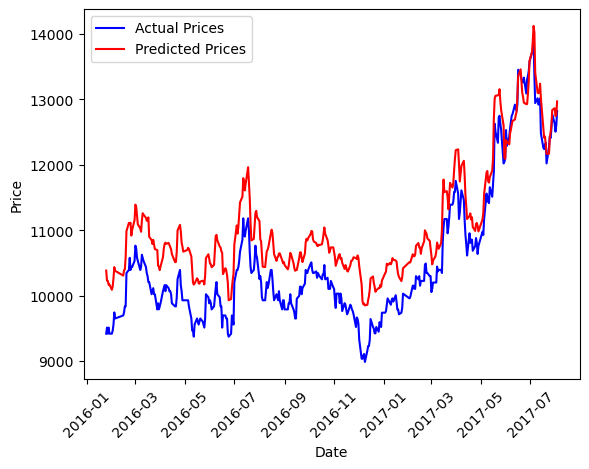

In [205]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ CSV
df = pd.read_csv("C:/Users/FPT/Documents/HK5/IE212/PythonCode/SSIHistoricalData.csv")

# Tiền xử lý dữ liệu
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
selected_columns = ["Price", "Open", "High", "Low", "Vol", "Change %"]

# Chuyển đổi kiểu dữ liệu và chuẩn hóa
df["Vol"] = df["Vol"].replace({',': ''}, regex=True).replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Xử lý cột "Change %"
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Xử lý các cột số có dấu phẩy
numeric_columns = ["Price", "Open", "High", "Low", "Vol"]
df[numeric_columns] = df[numeric_columns].replace({',': ''}, regex=True).astype(float)

# Tóm tắt thống kê của DataFrame
summary = df.describe()
print(summary)

# Chuẩn hóa giá trị
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_columns])

# Chuẩn bị dữ liệu cho mô hình LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length-1:i+seq_length, 0]  # Dự đoán giá trị "Price"
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 100  # Độ dài của mỗi chuỗi
X, y = create_sequences(scaled_data, seq_length)

# Chia thành tập huấn luyện và tập kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Chuyển đổi thành PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Định nghĩa mô hình LSTM để dự đoán giá trị "Price"
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Tạo và huấn luyện mô hình LSTM mới
input_size = X_train_tensor.shape[2]
output_size = 1  # Dự đoán chỉ cột "Price"
hidden_size = 100
dropout_rate = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_rate)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Dự đoán trên tập kiểm thử
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor[:, 0], test_outputs[:, 0])
    print(f'Mean Squared Error on Test Data: {mse}')

# Tính toán giá trị trung bình và độ lệch chuẩn của dữ liệu gốc
original_means = df[selected_columns].mean().values
original_stds = df[selected_columns].std().values

# Chuẩn hóa ngược lại giá trị của y_test
y_test_original = (y_test[:, 0] * original_stds[0]) + original_means[0]

# Chuẩn hóa ngược lại giá trị của test_outputs
test_outputs_original = (test_outputs[:, 0] * original_stds[0]) + original_means[0]

# Hiển thị trên đồ thị
plt.plot(df.index[-len(y_test):], y_test_original, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], test_outputs_original, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
